In [2]:
# Import packages
import cvxpy as cp
import gurobipy
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tabulate import tabulate

In [4]:
path=os.getcwd()
# https://www.energy.ca.gov/data-reports/energy-almanac/california-electricity-data/quarterly-fuel-and-energy-report-qfer-1
generation_info = pd.read_csv(path+"/data/"+"GenerationCali2021.csv")
generation_info['Energy Type'] = generation_info['CEC Plant ID'].str[0]
generation_info

generation_summary = generation_info.groupby('Energy Type')['Capacity (MW)'].sum().reset_index()
generation_summary['Dispatchable']=[1,1,1,1,1,1,0,1,0]
# Rename the categories
energy_type_map = {
    'G': 'Natural Gas',
    'S': 'Solar',
    'T': 'Geothermal',
    'N': 'Nuclear',
    'C': 'Coal',
    'E': 'Biomass',
    'H': 'Hydro',
    'W': 'Wind'
}

generation_summary['Energy Type'] = generation_summary['Energy Type'].map(energy_type_map)
print(generation_summary)
print('Net capacity:', generation_summary['Capacity (MW)'].sum())

   Energy Type  Capacity (MW)  Dispatchable
0         Coal           1899             1
1      Biomass           1258             1
2          NaN              3             1
3  Natural Gas          41659             1
4        Hydro          16137             1
5      Nuclear           2393             1
6        Solar          18233             0
7   Geothermal           2765             1
8         Wind           6643             0
Net capacity: 90990


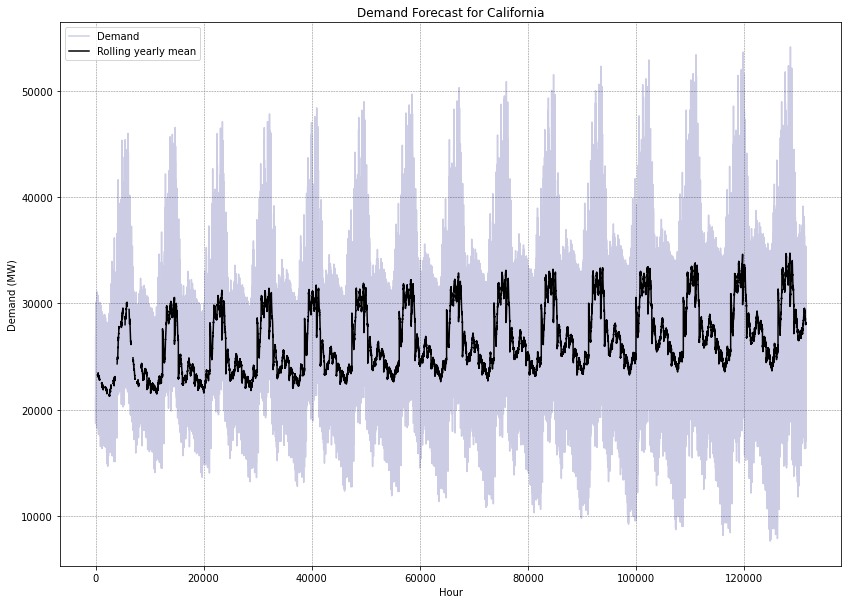

In [5]:
import matplotlib.pyplot as plt

# Read the demand forecast data
# https://www.energy.ca.gov/data-reports/reports/integrated-energy-policy-report/2021-integrated-energy-policy-report/2021-1
demand_forecast = pd.read_csv(path + "/data/" + "DemandForecastCali.csv")

# Calculate the rolling monthly mean of the 'Demand' column
demand_forecast['Rolling yearly mean'] = demand_forecast.groupby('month')['Demand'].rolling(window=365).mean().reset_index(level=0, drop=True)

# Plot settings
plt.figure(figsize=(14, 10))
plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')
plt.plot(demand_forecast['hour_yearly'], demand_forecast['Demand'], color='navy', alpha=0.2, label='Demand')
plt.plot(demand_forecast['hour_yearly'], demand_forecast['Rolling yearly mean'], color='black', label='Rolling yearly mean') # Add the rolling mean line

plt.xlabel('Hour')
plt.ylabel('Demand (MW)')
plt.title('Demand Forecast for California')
plt.legend()
plt.show()


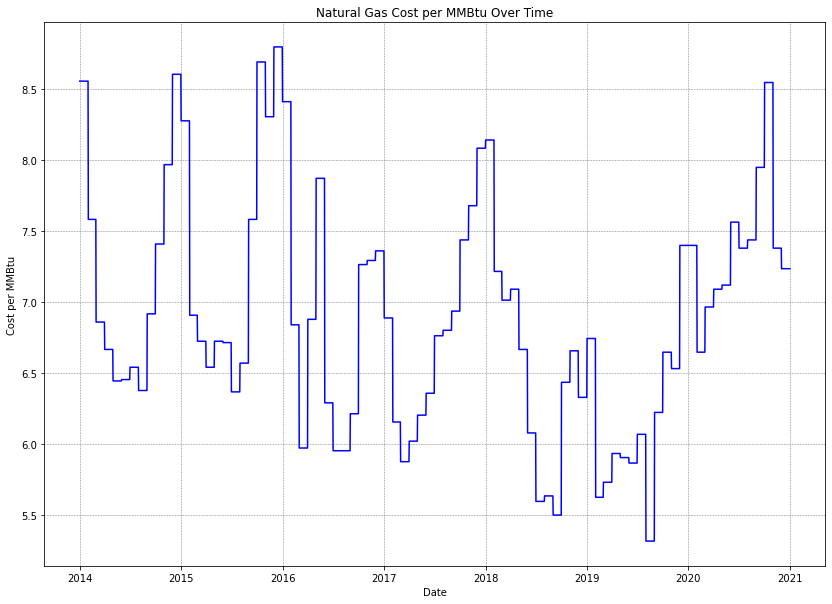

,date,Cost_per_thousand_cubic_feet,day,Cost_per_MMBtu
0,2014-01-01,8.87,1,8.553520
1,2014-01-02,8.87,2,8.553520
2,2014-01-03,8.87,3,8.553520
3,2014-01-04,8.87,4,8.553520
4,2014-01-05,8.87,5,8.553520
...,...,...,...,...
2552,2020-12-27,7.50,2553,7.232401
2553,2020-12-28,7.50,2554,7.232401
2554,2020-12-29,7.50,2555,7.232401
2555,2020-12-30,7.50,2556,7.232401


In [6]:
#daily NG prices

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Read the NG_cost DataFrame
NG_cost = pd.read_csv(path + "/data/" + "NG_cost.csv")

# Initialize an empty DataFrame to store the daily prices
daily_prices = pd.DataFrame()

# Loop over each row in NG_cost
for index, row in NG_cost.iterrows():
    month_start = pd.to_datetime(row['month'], format='%b-%y')
    # Create a date range for the month
    daily_index = pd.date_range(start=month_start, freq='D', periods=row['days_in_month'])
    
    # Create a new DataFrame for the month with daily prices
    daily_price = pd.DataFrame({'date': daily_index, 'price': row['price']})
    
    # Append to daily_prices DataFrame
    daily_prices = pd.concat([daily_prices, daily_price])

# Reset the index
daily_prices.reset_index(drop=True, inplace=True)
daily_prices['day'] = np.arange(1, len(daily_prices) + 1)

# Add other cost units
daily_prices.rename(columns={'price': 'Cost_per_thousand_cubic_feet'}, inplace=True)
daily_prices['Cost_per_MMBtu'] = daily_prices['Cost_per_thousand_cubic_feet'] / 1.037

# Plotting
plt.figure(figsize=(14, 10))
plt.plot(daily_prices['date'], daily_prices['Cost_per_MMBtu'], color='blue')
plt.xlabel('Date')
plt.ylabel('Cost per MMBtu')
plt.title('Natural Gas Cost per MMBtu Over Time')
plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')
plt.show()

# Uncomment below to save as CSV
daily_prices.to_csv('daily_ng_price.csv')
daily_prices

In [7]:
# NG cost monthly

NG_cost=pd.read_csv(path+"/data/"+"NG_cost.csv")
# Create an empty DataFrame to store the hourly prices
hourly_prices = pd.DataFrame()

# Iterate through the NG_cost DataFrame and repeat the price for each hour in the month
for index, row in NG_cost.iterrows():
    month_start = pd.to_datetime(row['month'], format='%b-%y')
    # If it's December, the next month is January of the next year
    if month_start.month == 12:
        month_end = pd.Timestamp(month_start.year + 1, 1, 1) - pd.Timedelta(seconds=1)
    else:
        month_end = pd.Timestamp(month_start.year, month_start.month % 12 + 1, 1) - pd.Timedelta(seconds=1)
    hourly_index = pd.date_range(start=month_start, end=month_end, freq='H')
    hourly_price = pd.DataFrame({'datetime': hourly_index, 'price': row['price']})
    hourly_prices = hourly_prices.append(hourly_price)

# Reset the index of the resulting DataFrame
hourly_prices.reset_index(drop=True, inplace=True)
hourly_prices.rename(columns={'price': 'Cost_per_thousand_cubic_feet'}, inplace=True)
hourly_prices['Cost_per_MMBtu']=hourly_prices['Cost_per_thousand_cubic_feet']/1.037
hourly_prices['hour']=np.arange(1,8761,1)

plt.figure(figsize=(14, 10))
plt.plot(hourly_prices['hour'], hourly_prices['Cost_per_MMBtu'], color='blue')
plt.xlabel('Hour')
plt.ylabel('Cost per MMBtu')
plt.title('Natural Gas Cost per MMBtu Over Time')
plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')
plt.show()
# hourly_prices.to_csv('hourly_ng_price.csv')

ValueError: Length of values (8760) does not match length of index (61368)

In [8]:
#Capacity mix analysis

national_capacity_mix=pd.read_csv(path+"/data/"+"national_generation_capacity_stacked.csv")

# Assuming df is your DataFrame containing the national_capacity_mix table
df = national_capacity_mix

# Group by 'country', 'year', and 'technology' columns and sum the 'capacity'
grouped_df = df.groupby(['country', 'year', 'technology'])['capacity'].sum().reset_index()

# Sort the DataFrame by 'country', 'year', and 'technology'
sorted_df = grouped_df.sort_values(['country', 'year', 'technology'])
print(df['country'].unique())

temp=sorted_df[(sorted_df['country'] == 'PL') & (sorted_df['year'] == 2016)]
temp=temp[temp['technology'] != 'Total']
temp['gen_cap_percentage']=temp['capacity']/(temp['capacity'].sum())*100
temp

['AT' 'BG' 'CH' 'CZ' 'DK' 'EE' 'ES' 'FI' 'FR' 'GB' 'GR' 'HR' 'IE' 'IT'
 'LU' 'LV' 'NL' 'NO' 'PL' 'PT' 'RO' 'SE' 'SI' 'SK' 'AL' 'BA' 'BE' 'CY'
 'DE' 'GE' 'HU' 'IS' 'LT' 'MD' 'ME' 'MK' 'MT' 'RS' 'TR' 'UA' 'XK' 'NI']


,country,year,technology,capacity,gen_cap_percentage
20076,PL,2016,Bioenergy and renewable waste,1386.67,0.553895
20077,PL,2016,Biomass and biogas,1126.17,0.449840
20078,PL,2016,Concentrated solar power,0.00,0.000000
20079,PL,2016,Differently categorized fossil fuels,29133.00,11.636959
20080,PL,2016,Differently categorized natural gas,2542.07,1.015411
20081,PL,2016,Differently categorized renewable energy sources,0.00,0.000000
20082,PL,2016,Differently categorized solar,77.25,0.030857
20083,PL,2016,Differently categorized wind,5747.00,2.295596
20084,PL,2016,Fossil fuels,85834.72,34.286037
20085,PL,2016,Geothermal,0.00,0.000000


In [9]:
# import pandas as pd

# Load and sort DataFrame
df = national_capacity_mix
grouped_df = df.groupby(['country', 'year', 'technology'])['capacity'].sum().reset_index()
sorted_df = grouped_df.sort_values(['country', 'year', 'technology'])

# Initialize variables
max_percentage = -1  # Initialize to a negative value to easily track if it gets updated
country_with_max = None
year_with_max = None

# Loop through each unique country and year
for country in df['country'].unique():
    for year in df['year'].unique():
        temp = sorted_df[(sorted_df['country'] == country) & (sorted_df['year'] == year)]
        temp = temp[temp['technology'] != 'Total']

        if temp.empty:
            continue

        total_capacity = temp['capacity'].sum()
        temp['gen_cap_percentage'] = (temp['capacity'] / total_capacity) * 100

        if 'Fossil fuels' in temp['technology'].values:
            fossil_fuel_percentage = temp.loc[temp['technology'] == 'Fossil fuels', 'gen_cap_percentage'].iloc[0]

            if fossil_fuel_percentage > max_percentage:
                max_percentage = fossil_fuel_percentage
                country_with_max = country
                year_with_max = year

# Ensure we found a country and year
if country_with_max:
    print(f"The country with the highest 'gen_cap_percentage' for 'Fossil fuel' is {country_with_max} in the year {year_with_max} with {max_percentage}%.")
else:
    print("No country found with 'Fossil fuel' technology in the given dataset for the specified year.")

The country with the highest 'gen_cap_percentage' for 'Fossil fuel' is CY in the year 1995 with 50.0%.


In [10]:
import pandas as pd

# Load and sort DataFrame
df = national_capacity_mix
grouped_df = df.groupby(['country', 'year', 'technology'])['capacity'].sum().reset_index()
sorted_df = grouped_df.sort_values(['country', 'year', 'technology'])

# Initialize variables
max_percentage = -1  # Initialize to a negative value to easily track if it gets updated
country_with_max = None
fixed_year = 2015  # Replace this with the year you are interested in

# Loop through each unique country for the fixed year
for country in df['country'].unique():
    temp = sorted_df[(sorted_df['country'] == country) & (sorted_df['year'] == fixed_year)]
    temp = temp[temp['technology'] != 'Total']

    if temp.empty:
        continue

    total_capacity = temp['capacity'].sum()
    temp['gen_cap_percentage'] = (temp['capacity'] / total_capacity) * 100

    if 'Fossil fuels' in temp['technology'].values:
        fossil_fuel_percentage = temp.loc[temp['technology'] == 'Fossil fuels', 'gen_cap_percentage'].iloc[0]

        if fossil_fuel_percentage > max_percentage:
            max_percentage = fossil_fuel_percentage
            country_with_max = country
            net_capacity=total_capacity

# Ensure we found a country
if country_with_max:
    print(f"The country with the highest 'gen_cap_percentage' for 'Fossil fuel' in the year {fixed_year} is {country_with_max} with {max_percentage}% and net capacity {net_capacity} ")
else:
    print(f"No country found with 'Fossil fuel' technology in the year {fixed_year}.")


The country with the highest 'gen_cap_percentage' for 'Fossil fuel' in the year 2015 is XK with 47.681083897863466% and net capacity 1919.0 


In [11]:
import pandas as pd

# Assume national_capacity_mix is your DataFrame
df = national_capacity_mix
grouped_df = df.groupby(['country', 'year', 'technology'])['capacity'].sum().reset_index()
sorted_df = grouped_df.sort_values(['country', 'year', 'technology'])

fixed_year = 2016  # Replace this with the year you are interested in

# Create an empty list to store the results
country_list = []

# Loop through each unique country for the fixed year
for country in df['country'].unique():
    temp = sorted_df[(sorted_df['country'] == country) & (sorted_df['year'] == fixed_year)]
    temp = temp[temp['technology'] != 'Total']

    if temp.empty:
        continue

    total_capacity = temp['capacity'].sum()
    temp['gen_cap_percentage'] = (temp['capacity'] / total_capacity) * 100

    if 'Wind' in temp['technology'].values:
        fossil_fuel_percentage = temp.loc[temp['technology'] == 'Wind', 'gen_cap_percentage'].iloc[0]
        country_list.append((country, fossil_fuel_percentage, total_capacity))

# Sort the list by 'gen_cap_percentage' in ascending order
sorted_country_list = sorted(country_list, key=lambda x: x[1])

# Print the sorted list
for country, percentage, net_capacity in sorted_country_list:
    print(f"Country: {country}, 'gen_cap_percentage' for 'Fossil fuels': {percentage}%, Net Capacity: {net_capacity}")


Country: AL, 'gen_cap_percentage' for 'Fossil fuels': 0.0%, Net Capacity: 4218.0
Country: BA, 'gen_cap_percentage' for 'Fossil fuels': 0.0%, Net Capacity: 8298.0
Country: ME, 'gen_cap_percentage' for 'Fossil fuels': 0.0%, Net Capacity: 1740.0
Country: MT, 'gen_cap_percentage' for 'Fossil fuels': 0.0%, Net Capacity: 1244.0
Country: SK, 'gen_cap_percentage' for 'Fossil fuels': 0.013688660541751553%, Net Capacity: 65747.85
Country: SI, 'gen_cap_percentage' for 'Fossil fuels': 0.04507988488841623%, Net Capacity: 32409.13333333333
Country: XK, 'gen_cap_percentage' for 'Fossil fuels': 0.04935834155972359%, Net Capacity: 2026.0
Country: IS, 'gen_cap_percentage' for 'Fossil fuels': 0.05408328826392645%, Net Capacity: 5547.0
Country: CH, 'gen_cap_percentage' for 'Fossil fuels': 0.09399412035445812%, Net Capacity: 127667.55999999997
Country: RS, 'gen_cap_percentage' for 'Fossil fuels': 0.11159249048181699%, Net Capacity: 15234.0
Country: MD, 'gen_cap_percentage' for 'Fossil fuels': 0.21436227224

In [12]:
load_solar_wind_variability=pd.read_csv(path+"/data/"+"time_series_60min_singleindex.csv")
# Assuming load_solar_wind_variability is your DataFrame and 'timestamp' is your UTC column
df = load_solar_wind_variability

# Convert the 'timestamp' column to datetime format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], utc=True)

# Create new columns for year, month, day, and hour
df['year'] = df['utc_timestamp'].dt.year
df['month'] = df['utc_timestamp'].dt.month
df['day'] = df['utc_timestamp'].dt.day
df['hour'] = df['utc_timestamp'].dt.hour
df.drop(0, inplace=True)

# Reset index if you want to
df.reset_index(drop=True, inplace=True)
df.fillna(0, inplace=True)

#Solar data filter
all_columns = df.columns.tolist()

# Filter columns that contain '_solar_generation_actual'
solar_columns = [col for col in all_columns if '_solar_generation_actual' in col]

# Columns you want to keep
columns_to_keep = ['utc_timestamp','year', 'month', 'day', 'hour'] + solar_columns

# Create new DataFrame
solar_variability = df[columns_to_keep]


#Wind data filter
wind_columns = [col for col in all_columns if '_wind_onshore_generation_actual' in col]

# Columns you want to keep
columns_to_keep = ['utc_timestamp','year', 'month', 'day', 'hour'] + wind_columns

# Create new DataFrame
wind_variability = df[columns_to_keep]


# Demand data filter
demand_columns = [col for col in all_columns if '_load_actual_entsoe_transparency' in col]

# Columns you want to keep
columns_to_keep = ['utc_timestamp','year', 'month', 'day', 'hour'] + demand_columns

# Create new DataFrame
demand_variability = df[columns_to_keep]

# Find the maximum values for each demand column
max_values = demand_variability[demand_columns].max()

# Convert the Series to a dictionary
max_values_dict = max_values.to_dict()

# Print or store max values
print("Maximum values for each column:")
for col, val in max_values_dict.items():
    print(f"{col}: {val}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/shinychoudhury/Library/CloudStorage/GoogleDrive-schoudh2@uci.edu/My Drive/TYNAN_Lab/USAEE 2023/Case_Competition/USAEE2023_Geothermal_TeamDavidsonLab_v2/data/time_series_60min_singleindex.csv'

In [1]:
demand_variability

NameError: name 'demand_variability' is not defined

In [146]:
# Merge the DataFrames on the common columns
merged_df = pd.merge(wind_variability, solar_variability, on=['year', 'month', 'day', 'hour'])

# Find the correlation between 'AT__wind_onshore_generation_actual' and 'AT__solar_generation_actual'
correlation = merged_df['AT_wind_onshore_generation_actual'].corr(merged_df['AT_solar_generation_actual'])

print(f"The correlation between 'AT__wind_onshore_generation_actual' and 'AT__solar_generation_actual' is {correlation}.")

The correlation between 'AT__wind_onshore_generation_actual' and 'AT__solar_generation_actual' is -0.09677035538951742.


<ipython-input-179-61bd52dee399>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_variability[wind_columns_to_normalize] = scaler.fit_transform(wind_variability[wind_columns_to_normalize])
/Users/shinychoudhury/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


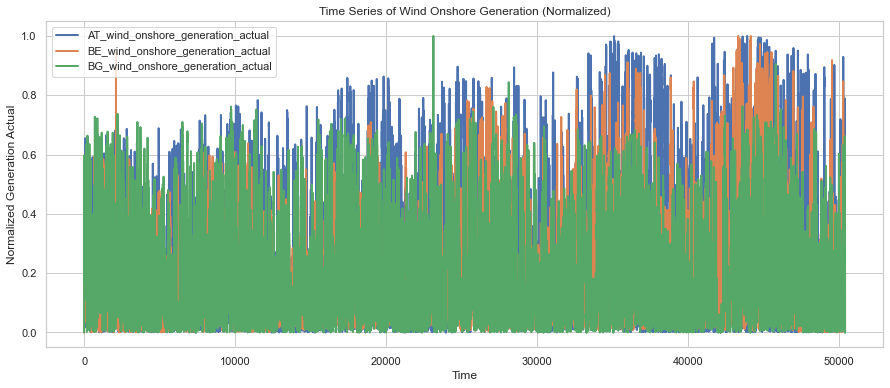

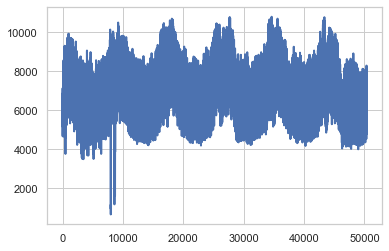

In [179]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Identify the specific columns to normalize
wind_columns_to_normalize = [col for col in wind_variability.columns if '_wind_onshore_generation_actual' in col]

# Apply Min-Max scaling to normalize the selected columns between 0 and 1
wind_variability[wind_columns_to_normalize] = scaler.fit_transform(wind_variability[wind_columns_to_normalize])

import matplotlib.pyplot as plt

# Make sure your DataFrame is indexed by time for meaningful plots
# If not, you can create a time index as mentioned in a previous answer

plt.figure(figsize=(15, 6))

# Plotting the columns
plt.plot(wind_variability.index, wind_variability['AT_wind_onshore_generation_actual'], label='AT_wind_onshore_generation_actual', linewidth=2)
plt.plot(wind_variability.index, wind_variability['BE_wind_onshore_generation_actual'], label='BE_wind_onshore_generation_actual', linewidth=2)
plt.plot(wind_variability.index, wind_variability['BG_wind_onshore_generation_actual'], label='BG_wind_onshore_generation_actual', linewidth=2)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Normalized Generation Actual')
plt.title('Time Series of Wind Onshore Generation (Normalized)')
plt.legend()

# Show the plot
plt.show()

plt.plot(demand_variability.index, demand_variability['AT_load_actual_entsoe_transparency'], label='AT_load_actual_entsoe_transparency', linewidth=2)


<ipython-input-164-bd94bf202f2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_variability[solar_columns_to_normalize] = scaler.fit_transform(solar_variability[solar_columns_to_normalize])
/Users/shinychoudhury/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


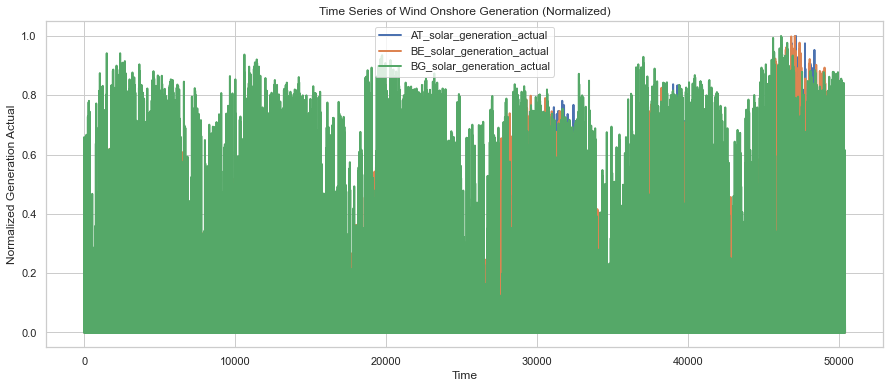

In [164]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Identify the specific columns to normalize
solar_columns_to_normalize = [col for col in solar_variability.columns if '_solar_generation_actual' in col]

# Apply Min-Max scaling to normalize the selected columns between 0 and 1
solar_variability[solar_columns_to_normalize] = scaler.fit_transform(solar_variability[solar_columns_to_normalize])


# Make sure your DataFrame is indexed by time for meaningful plots
# If not, you can create a time index as mentioned in a previous answer

plt.figure(figsize=(15, 6))

# Plotting the columns
plt.plot(solar_variability.index, solar_variability['AT_solar_generation_actual'], label='AT_solar_generation_actual', linewidth=2)
plt.plot(solar_variability.index, solar_variability['BE_solar_generation_actual'], label='BE_solar_generation_actual', linewidth=2)
plt.plot(solar_variability.index, solar_variability['BG_solar_generation_actual'], label='BG_solar_generation_actual', linewidth=2)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Normalized Generation Actual')
plt.title('Time Series of Wind Onshore Generation (Normalized)')
plt.legend()

# Show the plot
plt.show()

demand_variability['AT_load_actual_entsoe_transparency'].to_csv('AT_demand.csv')
wind_variability['AT_wind_onshore_generation_actual'].to_csv('AT_wind_variability.csv')
solar_variability['AT_solar_generation_actual'].to_csv('AT_solar_variability.csv')

<ipython-input-158-f5aa4c716fa1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_variability['AT_monthly_mean'] = solar_variability['AT_solar_generation_actual'].rolling(window=window_size).mean()
<ipython-input-158-f5aa4c716fa1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_variability['BE_monthly_mean'] = solar_variability['BE_solar_generation_actual'].rolling(window=window_size).mean()
<ipython-input-158-f5aa4c716fa1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

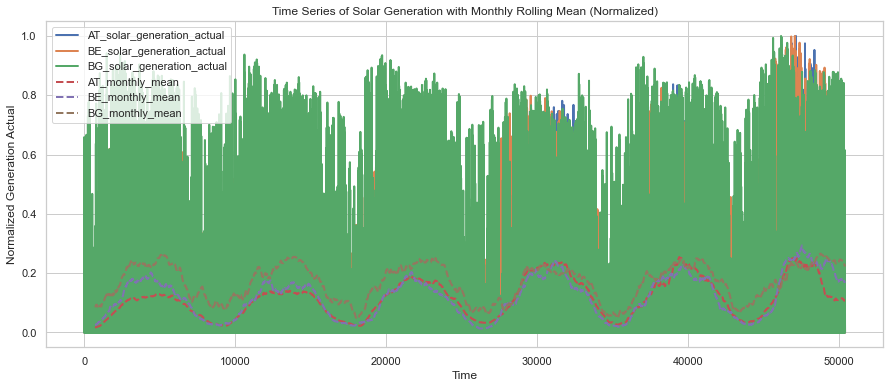

In [158]:
import matplotlib.pyplot as plt

# Rolling monthly mean
window_size = 24*30  # You can adjust this based on how your data is sampled
solar_variability['AT_monthly_mean'] = solar_variability['AT_solar_generation_actual'].rolling(window=window_size).mean()
solar_variability['BE_monthly_mean'] = solar_variability['BE_solar_generation_actual'].rolling(window=window_size).mean()
solar_variability['BG_monthly_mean'] = solar_variability['BG_solar_generation_actual'].rolling(window=window_size).mean()

plt.figure(figsize=(15, 6))

# Plotting the original columns
plt.plot(solar_variability.index, solar_variability['AT_solar_generation_actual'], label='AT_solar_generation_actual', linewidth=2)
plt.plot(solar_variability.index, solar_variability['BE_solar_generation_actual'], label='BE_solar_generation_actual', linewidth=2)
plt.plot(solar_variability.index, solar_variability['BG_solar_generation_actual'], label='BG_solar_generation_actual', linewidth=2)

# Plotting the rolling monthly mean
plt.plot(solar_variability.index, solar_variability['AT_monthly_mean'], label='AT_monthly_mean', linestyle='--', linewidth=2)
plt.plot(solar_variability.index, solar_variability['BE_monthly_mean'], label='BE_monthly_mean', linestyle='--', linewidth=2)
plt.plot(solar_variability.index, solar_variability['BG_monthly_mean'], label='BG_monthly_mean', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Normalized Generation Actual')
plt.title('Time Series of Solar Generation with Monthly Rolling Mean (Normalized)')
plt.legend()

# Show the plot
plt.show()


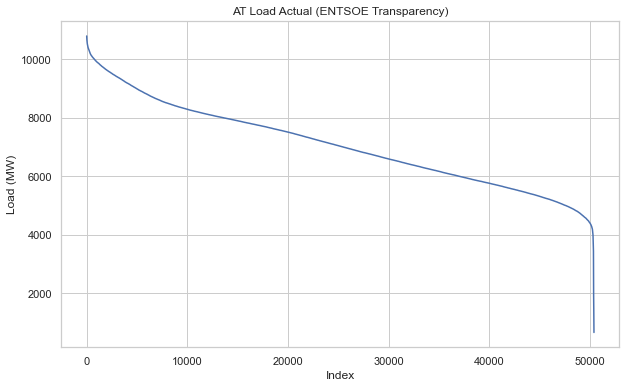

0        10803.0
1        10788.0
2        10783.0
3        10779.0
4        10744.0
          ...   
50395     1016.0
50396      960.0
50397      948.0
50398      837.0
50399      664.0
Name: AT_load_actual_entsoe_transparency, Length: 50400, dtype: float64

In [186]:
#load analysis
load_AT=demand_variability['AT_load_actual_entsoe_transparency'].sort_values(ascending=False).reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(load_AT)
plt.xlabel('Index')
plt.ylabel('Load (MW)')
plt.title('AT Load Actual (ENTSOE Transparency)')
plt.grid(True)
plt.show()
load_AT